In [351]:
import torch

PATH="/export/data4/vzhekova/biases-data/Test_De/Statistics"
FASTBPE="/home/vzhekova/fastBPE/fast" # path to the fastBPE tool

In [352]:
# check if we can connect to the GPU with PyTorch
if torch.cuda.is_available():
    device = torch.cuda.current_device()
    print('Current device:', torch.cuda.get_device_name(device))
else:
    print('Failed to find GPU. Will use CPU.')
    device = 'cpu'

Current device: GeForce GTX 1080 Ti


In [353]:
%cd $PATH

/export/data4/vzhekova/biases-data/Test_De/Statistics


In [21]:
# Extract original sentences
!cut -f3 -d'	' en.txt > en_original.txt

In [10]:
import csv

# Convert text file to csv
with open('en.txt', 'r') as in_file:
    stripped = (line.strip() for line in in_file)
    lines = (line.split("	") for line in stripped if line)
    with open('en.csv', 'w') as out_file:
        writer = csv.writer(out_file)
        #writer.writerow(('gender', 'position', 'sentence', 'word'))
        writer.writerows(lines)

In [ ]:
# Extract gender word tokens
with open('en.csv') as csv_file, open('tokens.txt', 'w') as out_file:
    csv_reader = csv.reader(csv_file)
    for row in csv_reader:
        position = int(row[1])
        sentence = row[2].split(" ")
        print(sentence[position], end='\n', file=out_file)

In [ ]:
# Extract gender ambiguous words
with open('en.csv') as csv_file, open('words.txt', 'w') as out_file:
    csv_reader = csv.reader(csv_file)
    for row in csv_reader:
        print(row[3], end='\n', file=out_file)

In [20]:
# Modify gender ambiguous words with correct gender from context
with open('en.csv') as csv_file, open('en_modified.txt', 'w') as out_file:
    csv_reader = csv.reader(csv_file)
    for row in csv_reader:
        modified = row[0] + " " + row[3]
        position = int(row[1])
        sentence = row[2].split(" ")
        sentence[position] = modified
        print(' '.join(sentence), end='\n', file=out_file)

In [294]:
# Modify gender ambiguous words with gender

# List with source words
words = set() # set forces uniqueness
with open('words.txt', 'r') as fin:
    for line in fin:
        words.add(line.strip())
        
#print(len(words))

with open('en.csv') as csv_file, open('en_disambiguated.txt', 'w') as out_file:
    csv_reader = csv.reader(csv_file)
    for row in csv_reader:
        modified = row[0] + " " + row[3]
        position = int(row[1])
        sentence = row[2].split(" ")
        sentence[position] = modified
        for token in sentence:
            if (token.replace(',', '') in words): # tokens often contain ","
                token_pos = sentence.index(token)
                sentence[token_pos] = "male " + token # could also replace with "female"
        print(' '.join(sentence), end='\n', file=out_file)

# Translation English-German

In [299]:
# Tokenization
from sacremoses import MosesPunctNormalizer
from sacremoses import MosesTokenizer, MosesDetokenizer
from __future__ import print_function

mpn = MosesPunctNormalizer()
mt_en = MosesTokenizer(lang='en')
md_en = MosesDetokenizer(lang='en')

with open('en_original.txt') as fin, open('tok.en_original.en','w') as fout:
    for line in fin:
        tokens = mt_en.tokenize(mpn.normalize(line), return_str=True)
        print(tokens, end='\n', file=fout) 
        
with open('en_disambiguated.txt') as fin, open('tok.en_disambiguated.en','w') as fout:
    for line in fin:
        tokens = mt_en.tokenize(mpn.normalize(line), return_str=True)
        print(tokens, end='\n', file=fout)

print('Finished tokenizing.')

Finished tokenizing.


In [300]:
# Dividing text into subword units

!$FASTBPE applybpe bpe.en_original.en tok.en_original.en bpecodes.en
!$FASTBPE applybpe bpe.en_disambiguated.en tok.en_disambiguated.en bpecodes.en

print('Finished subword.')

Loading codes from bpecodes.en ...
Read 30000 codes from the codes file.
Loading vocabulary from tok.en_original.en ...
Read 55693 words (1890 unique) from text file.
Applying BPE to tok.en_original.en ...
Modified 55693 words from text file.
Loading codes from bpecodes.en ...
Read 30000 codes from the codes file.
Loading vocabulary from tok.en_disambiguated.en ...
Read 63597 words (1893 unique) from text file.
Applying BPE to tok.en_disambiguated.en ...
Modified 63597 words from text file.
Finished subword.


In [301]:
# Binarize text
!fairseq-preprocess \
    --source-lang en \
    --target-lang de \
    --testpref bpe.en_original \
    --only-source \
    --srcdict /export/data4/vzhekova/biases-data/En-De/wmt19.en-de.joined-dict.ensemble/dict.en.txt \
    --tgtdict /export/data4/vzhekova/biases-data/En-De/wmt19.en-de.joined-dict.ensemble/dict.de.txt \
    --destdir data-bin_original_en-de \
    --workers 8

2023-04-05 17:14:51 | INFO | fairseq_cli.preprocess | Namespace(aim_repo=None, aim_run_hash=None, align_suffix=None, alignfile=None, all_gather_list_size=16384, amp=False, amp_batch_retries=2, amp_init_scale=128, amp_scale_window=None, azureml_logging=False, bf16=False, bpe=None, cpu=False, criterion='cross_entropy', dataset_impl='mmap', destdir='data-bin_original_en-de', dict_only=False, empty_cache_freq=0, fp16=False, fp16_init_scale=128, fp16_no_flatten_grads=False, fp16_scale_tolerance=0.0, fp16_scale_window=None, joined_dictionary=False, log_file=None, log_format=None, log_interval=100, lr_scheduler='fixed', memory_efficient_bf16=False, memory_efficient_fp16=False, min_loss_scale=0.0001, model_parallel_size=1, no_progress_bar=False, nwordssrc=-1, nwordstgt=-1, on_cpu_convert_precision=False, only_source=True, optimizer=None, padding_factor=8, plasma_path='/tmp/plasma', profile=False, quantization_config_path=None, reset_logging=False, scoring='bleu', seed=1, source_lang='en', srcd

In [ ]:
!fairseq-preprocess \
    --source-lang en \
    --target-lang de \
    --testpref bpe.en_disambiguated \
    --only-source \
    --srcdict /export/data4/vzhekova/biases-data/En-De/wmt19.en-de.joined-dict.ensemble/dict.en.txt \
    --tgtdict /export/data4/vzhekova/biases-data/En-De/wmt19.en-de.joined-dict.ensemble/dict.de.txt \
    --destdir data-bin_disambiguated_en-de \
    --workers 8

In [329]:
MODELS="/export/data4/vzhekova/biases-data/En-De/wmt19.en-de.joined-dict.ensemble"
NBEST = 10
BEAM = 10

In [302]:
# Generate N hypothesis
!fairseq-generate data-bin_original_en-de  \
    --task translation \
    --source-lang en \
    --target-lang de \
    --path $MODELS/model1.pt:$MODELS/model2.pt:$MODELS/model3.pt:$MODELS/model4.pt \
    --beam $BEAM \
    --nbest $NBEST \
    --batch-size 64 \
    --memory-efficient-fp16 \
    --remove-bpe > original_en-de.decode_Beam_10.log

2023-04-05 17:15:10 | INFO | fairseq_cli.generate | {'_name': None, 'common': {'_name': None, 'no_progress_bar': False, 'log_interval': 100, 'log_format': None, 'log_file': None, 'aim_repo': None, 'aim_run_hash': None, 'tensorboard_logdir': None, 'wandb_project': None, 'azureml_logging': False, 'seed': 1, 'cpu': False, 'tpu': False, 'bf16': False, 'memory_efficient_bf16': False, 'fp16': True, 'memory_efficient_fp16': True, 'fp16_no_flatten_grads': False, 'fp16_init_scale': 128, 'fp16_scale_window': None, 'fp16_scale_tolerance': 0.0, 'on_cpu_convert_precision': False, 'min_loss_scale': 0.0001, 'threshold_loss_scale': None, 'amp': False, 'amp_batch_retries': 2, 'amp_init_scale': 128, 'amp_scale_window': None, 'user_dir': None, 'empty_cache_freq': 0, 'all_gather_list_size': 16384, 'model_parallel_size': 1, 'quantization_config_path': None, 'profile': False, 'reset_logging': False, 'suppress_crashes': False, 'use_plasma_view': False, 'plasma_path': '/tmp/plasma'}, 'common_eval': {'_name': 

In [330]:
# Generate N hypothesis
!fairseq-generate data-bin_disambiguated_en-de  \
    --task translation \
    --source-lang en \
    --target-lang de \
    --path $MODELS/model1.pt:$MODELS/model2.pt:$MODELS/model3.pt:$MODELS/model4.pt \
    --beam $BEAM \
    --nbest $NBEST \
    --batch-size 64 \
    --memory-efficient-fp16 \
    --remove-bpe > disambiguated_en-de.decode_Beam_10.log

2023-04-06 12:48:52 | INFO | fairseq_cli.generate | {'_name': None, 'common': {'_name': None, 'no_progress_bar': False, 'log_interval': 100, 'log_format': None, 'log_file': None, 'aim_repo': None, 'aim_run_hash': None, 'tensorboard_logdir': None, 'wandb_project': None, 'azureml_logging': False, 'seed': 1, 'cpu': False, 'tpu': False, 'bf16': False, 'memory_efficient_bf16': False, 'fp16': True, 'memory_efficient_fp16': True, 'fp16_no_flatten_grads': False, 'fp16_init_scale': 128, 'fp16_scale_window': None, 'fp16_scale_tolerance': 0.0, 'on_cpu_convert_precision': False, 'min_loss_scale': 0.0001, 'threshold_loss_scale': None, 'amp': False, 'amp_batch_retries': 2, 'amp_init_scale': 128, 'amp_scale_window': None, 'user_dir': None, 'empty_cache_freq': 0, 'all_gather_list_size': 16384, 'model_parallel_size': 1, 'quantization_config_path': None, 'profile': False, 'reset_logging': False, 'suppress_crashes': False, 'use_plasma_view': False, 'plasma_path': '/tmp/plasma'}, 'common_eval': {'_name': 

# Backtranslation German-English

In [331]:
# 'LC_ALL=C sort -V' sorts the results in natural order 
!grep ^H original_en-de.decode_Beam_10.log | LC_ALL=C sort -V | sed 's/^H-//g' | cut -f 3 | sed 's/ @@//g' > ./hyp_original.txt
!grep ^H disambiguated_en-de.decode_Beam_10.log | LC_ALL=C sort -V | sed 's/^H-//g' | cut -f 3 | sed 's/ @@//g' > ./hyp_disambiguated.txt

In [332]:
# Dividing tokenized text into subword units

!$FASTBPE applybpe bpe.hyp_original.de hyp_original.txt bpecodes.de
!$FASTBPE applybpe bpe.hyp_disambiguated.de hyp_disambiguated.txt bpecodes.de

print('Finished subword.')

Loading codes from bpecodes.de ...
Read 30000 codes from the codes file.
Loading vocabulary from hyp_original.txt ...
Read 584204 words (4631 unique) from text file.
Applying BPE to hyp_original.txt ...
Modified 584204 words from text file.
Loading codes from bpecodes.de ...
Read 30000 codes from the codes file.
Loading vocabulary from hyp_disambiguated.txt ...
Read 638095 words (4634 unique) from text file.
Applying BPE to hyp_disambiguated.txt ...
Modified 638095 words from text file.
Finished subword.


In [317]:
!fairseq-preprocess \
    --source-lang de \
    --target-lang en \
    --only-source \
    --testpref bpe.hyp_original \
    --srcdict /export/data4/vzhekova/biases-data/De-En/wmt19.de-en.joined-dict.ensemble/dict.de.txt \
    --tgtdict /export/data4/vzhekova/biases-data/De-En/wmt19.de-en.joined-dict.ensemble/dict.en.txt \
    --destdir data-bin_original_de-en \
    --workers 8

2023-04-06 11:03:11 | INFO | fairseq_cli.preprocess | Namespace(aim_repo=None, aim_run_hash=None, align_suffix=None, alignfile=None, all_gather_list_size=16384, amp=False, amp_batch_retries=2, amp_init_scale=128, amp_scale_window=None, azureml_logging=False, bf16=False, bpe=None, cpu=False, criterion='cross_entropy', dataset_impl='mmap', destdir='data-bin_original_de-en', dict_only=False, empty_cache_freq=0, fp16=False, fp16_init_scale=128, fp16_no_flatten_grads=False, fp16_scale_tolerance=0.0, fp16_scale_window=None, joined_dictionary=False, log_file=None, log_format=None, log_interval=100, lr_scheduler='fixed', memory_efficient_bf16=False, memory_efficient_fp16=False, min_loss_scale=0.0001, model_parallel_size=1, no_progress_bar=False, nwordssrc=-1, nwordstgt=-1, on_cpu_convert_precision=False, only_source=True, optimizer=None, padding_factor=8, plasma_path='/tmp/plasma', profile=False, quantization_config_path=None, reset_logging=False, scoring='bleu', seed=1, source_lang='de', srcd

In [333]:
!fairseq-preprocess \
    --source-lang de \
    --target-lang en \
    --only-source \
    --testpref bpe.hyp_disambiguated \
    --srcdict /export/data4/vzhekova/biases-data/De-En/wmt19.de-en.joined-dict.ensemble/dict.de.txt \
    --tgtdict /export/data4/vzhekova/biases-data/De-En/wmt19.de-en.joined-dict.ensemble/dict.en.txt \
    --destdir data-bin_disambiguated_de-en \
    --workers 8

2023-04-06 12:58:33 | INFO | fairseq_cli.preprocess | Namespace(aim_repo=None, aim_run_hash=None, align_suffix=None, alignfile=None, all_gather_list_size=16384, amp=False, amp_batch_retries=2, amp_init_scale=128, amp_scale_window=None, azureml_logging=False, bf16=False, bpe=None, cpu=False, criterion='cross_entropy', dataset_impl='mmap', destdir='data-bin_disambiguated_de-en', dict_only=False, empty_cache_freq=0, fp16=False, fp16_init_scale=128, fp16_no_flatten_grads=False, fp16_scale_tolerance=0.0, fp16_scale_window=None, joined_dictionary=False, log_file=None, log_format=None, log_interval=100, lr_scheduler='fixed', memory_efficient_bf16=False, memory_efficient_fp16=False, min_loss_scale=0.0001, model_parallel_size=1, no_progress_bar=False, nwordssrc=-1, nwordstgt=-1, on_cpu_convert_precision=False, only_source=True, optimizer=None, padding_factor=8, plasma_path='/tmp/plasma', profile=False, quantization_config_path=None, reset_logging=False, scoring='bleu', seed=1, source_lang='de',

In [334]:
MODELS="/export/data4/vzhekova/biases-data/De-En/wmt19.de-en.joined-dict.ensemble"
NBEST = 10
BEAM = 10

In [307]:
# Generate N hypothesis
!fairseq-generate data-bin_original_de-en  \
    --task translation \
    --source-lang de \
    --target-lang en \
    --path $MODELS/model1.pt:$MODELS/model2.pt:$MODELS/model3.pt:$MODELS/model4.pt \
    --beam $BEAM \
    --nbest $NBEST \
    --batch-size 64 \
    --memory-efficient-fp16 \
    --remove-bpe > original_de-en.decode_Beam_10_backtranslation.log

2023-04-05 17:24:59 | INFO | fairseq_cli.generate | {'_name': None, 'common': {'_name': None, 'no_progress_bar': False, 'log_interval': 100, 'log_format': None, 'log_file': None, 'aim_repo': None, 'aim_run_hash': None, 'tensorboard_logdir': None, 'wandb_project': None, 'azureml_logging': False, 'seed': 1, 'cpu': False, 'tpu': False, 'bf16': False, 'memory_efficient_bf16': False, 'fp16': True, 'memory_efficient_fp16': True, 'fp16_no_flatten_grads': False, 'fp16_init_scale': 128, 'fp16_scale_window': None, 'fp16_scale_tolerance': 0.0, 'on_cpu_convert_precision': False, 'min_loss_scale': 0.0001, 'threshold_loss_scale': None, 'amp': False, 'amp_batch_retries': 2, 'amp_init_scale': 128, 'amp_scale_window': None, 'user_dir': None, 'empty_cache_freq': 0, 'all_gather_list_size': 16384, 'model_parallel_size': 1, 'quantization_config_path': None, 'profile': False, 'reset_logging': False, 'suppress_crashes': False, 'use_plasma_view': False, 'plasma_path': '/tmp/plasma'}, 'common_eval': {'_name': 

In [335]:
# Generate N hypothesis
!fairseq-generate data-bin_disambiguated_de-en  \
    --task translation \
    --source-lang de \
    --target-lang en \
    --path $MODELS/model1.pt:$MODELS/model2.pt:$MODELS/model3.pt:$MODELS/model4.pt \
    --beam $BEAM \
    --nbest $NBEST \
    --batch-size 64 \
    --memory-efficient-fp16 \
    --remove-bpe > disambiguated_de-en.decode_Beam_10_backtranslation.log

2023-04-06 12:58:49 | INFO | fairseq_cli.generate | {'_name': None, 'common': {'_name': None, 'no_progress_bar': False, 'log_interval': 100, 'log_format': None, 'log_file': None, 'aim_repo': None, 'aim_run_hash': None, 'tensorboard_logdir': None, 'wandb_project': None, 'azureml_logging': False, 'seed': 1, 'cpu': False, 'tpu': False, 'bf16': False, 'memory_efficient_bf16': False, 'fp16': True, 'memory_efficient_fp16': True, 'fp16_no_flatten_grads': False, 'fp16_init_scale': 128, 'fp16_scale_window': None, 'fp16_scale_tolerance': 0.0, 'on_cpu_convert_precision': False, 'min_loss_scale': 0.0001, 'threshold_loss_scale': None, 'amp': False, 'amp_batch_retries': 2, 'amp_init_scale': 128, 'amp_scale_window': None, 'user_dir': None, 'empty_cache_freq': 0, 'all_gather_list_size': 16384, 'model_parallel_size': 1, 'quantization_config_path': None, 'profile': False, 'reset_logging': False, 'suppress_crashes': False, 'use_plasma_view': False, 'plasma_path': '/tmp/plasma'}, 'common_eval': {'_name': 

In [336]:
# 'LC_ALL=C sort -V' sorts the results in natural order 
!grep ^H original_de-en.decode_Beam_10_backtranslation.log | LC_ALL=C sort -V | sed 's/^H-//g' | cut -f 3 | sed 's/ @@//g' > ./hyp_original_back.txt
!grep ^H disambiguated_de-en.decode_Beam_10_backtranslation.log | LC_ALL=C sort -V | sed 's/^H-//g' | cut -f 3 | sed 's/ @@//g' > ./hyp_disambiguated_back.txt

In [337]:
# Detokenize text        
from sacremoses import MosesPunctNormalizer
from sacremoses import MosesTokenizer, MosesDetokenizer
from __future__ import print_function

md_en = MosesDetokenizer(lang='en')

with open('hyp_original_back.txt', encoding='utf8') as fin, open('original_back.txt','w', encoding='utf8') as fout:
    for line in fin:
        tokens = md_en.detokenize(line.split(), return_str=True)
        print(tokens, end='\n', file=fout)
        
with open('hyp_disambiguated_back.txt', encoding='utf8') as fin, open('disambiguated_back.txt','w', encoding='utf8') as fout:
    for line in fin:
        tokens = md_en.detokenize(line.split(), return_str=True)
        print(tokens, end='\n', file=fout)

print('Finished detokenizing.')

Finished detokenizing.


# Statistics

In [356]:
# List with original source sentences
source = []
with open('en_original.txt', 'r') as fin:
    for line in fin:
        source.append(line.strip())
        
# List with disambiguated source sentences
source_disambiguated = []
with open('en_disambiguated.txt', 'r') as fin:
    for line in fin:
        source_disambiguated.append(line.strip())
    
# List with nbest sentences for every source
nbest_original = []
counter = 0
temp = []
with open('original_back.txt', 'r') as fin:
    for line in fin:
        temp.append(line.strip())
        counter += 1
        if (counter == 100):
            nbest_original.append(temp)
            counter = 0
            temp = []
            
nbest_modified = []
with open('disambiguated_back.txt', 'r') as fin:
    for line in fin:
        temp.append(line.strip())
        counter += 1
        if (counter == 100):
            nbest_modified.append(temp)
            counter = 0
            temp = []
            
print(len(source))
print(len(nbest_original))
print(len(nbest_modified))

3888
3888
3888


## Source sentence occurrence

In [357]:
# Count how many times the source sentence occurs in the nbest list of original
results = []
counter = 0
for sent in source:
    matches = 0
    for target in nbest_original[counter]: 
        if (sent == target):
            matches += 1
    results.append(matches)  
    counter += 1
    
print(sum(results))
print(sum(x > 0 for x in results))

10443
1836


In [358]:
# Count how many times the source sentence occurs in the nbest list of modified
results = []
counter = 0
for sent in source_disambiguated:
    matches = 0
    for target in nbest_modified[counter]: 
        if (sent == target):
            matches += 1
    results.append(matches)  
    counter += 1
    
print(sum(results))
print(sum(x > 0 for x in results))

4895
1056


In [341]:
# Extract gender ambiguous words
with open('en.csv') as csv_file, open('words.txt', 'w') as out_file:
    csv_reader = csv.reader(csv_file)
    for row in csv_reader:
        print(row[3], end='\n', file=out_file)

In [342]:
# List with source words
source = []
with open('words.txt', 'r') as fin:
    for line in fin:
        source.append(line.strip())
        
# List with nbest sentences for every source
nbest_original = []
counter = 0
temp = []
with open('original_back.txt', 'r') as fin:
    for line in fin:
        temp.append(line.strip())
        counter += 1
        if (counter == 100):
            nbest_original.append(temp)
            counter = 0
            temp = []

nbest_modified = []
with open('disambiguated_back.txt', 'r') as fin:
    for line in fin:
        temp.append(line.strip())
        counter += 1
        if (counter == 100):
            nbest_modified.append(temp)
            counter = 0
            temp = []  

print(len(source))
print(len(nbest_original))
print(len(nbest_modified))     

3888
3888
3888


## Ambiguous source words occurrence

In [343]:
# Count how many times the source words occurs in the nbest list of original
results = []
counter = 0
for word in source:
    matches = 0
    for target in nbest_original[counter]: 
        if (word in target.split(" ")):
            matches += 1
    results.append(matches)  
    counter += 1
    
print(sum(results))
print(sum(x > 0 for x in results))

242903
3409


In [344]:
# Count how many times the source words occurs in the nbest list of modified
results = []
counter = 0
for word in source:
    matches = 0
    for target in nbest_modified[counter]: 
        if (word in target.split(" ")):
            matches += 1
    results.append(matches)  
    counter += 1
    
print(sum(results))
print(sum(x > 0 for x in results))

233948
3327


## Count unique sentences

In [345]:
# Count unique sentences in source nbest list for each source sentence of original
unique_sent = []
for source_nbest in nbest_original:
    num_values = len(set(source_nbest))
    #print(num_values)
    unique_sent.append(num_values)
    
#print(unique_sent)
print(sum(unique_sent)/3888) # average

43.48688271604938


In [346]:
# Count unique sentences in source nbest list for each source sentence of modified
unique_sent = []
for source_nbest in nbest_modified:
    num_values = len(set(source_nbest))
    #print(num_values)
    unique_sent.append(num_values)
    
#print(unique_sent)
print(sum(unique_sent)/3888) # average

48.79526748971193


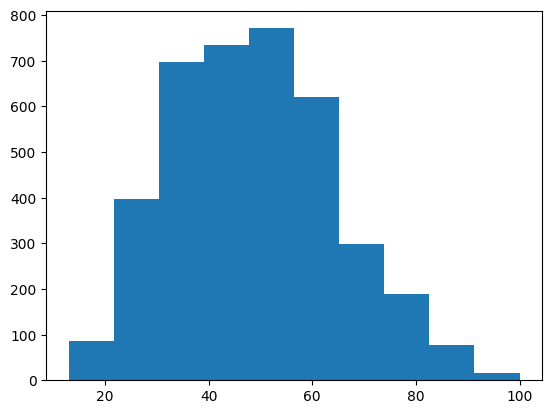

In [347]:
import numpy as np
import matplotlib.pyplot as plt

#plt.bar(np.arange(len(unique_sent)), unique_sent)
plt.hist(unique_sent, bins=10)
plt.show()


## Count unique words

In [ ]:
# Count unique words in source nbest list for each source sentence of original; 18.261574074074073
import spacy

sp = spacy.load('en_core_web_sm')
stopwords = spacy.lang.en.stop_words.STOP_WORDS


unique_words = []
counter = 0
for source_nbest in nbest_original:
    words = set()
    for sent in source_nbest:
        tokens = sp(sent)
        for token in tokens:
            if token.text not in stopwords:    # checking whether the word is a stop word
                words.add(token.text)
    num_values = len(words)
    unique_words.append(num_values)
    
    counter += 1
    print(counter)
    
#print(unique_words)
print(sum(unique_words)/3888)

In [ ]:
# Count unique words in source nbest list for each source sentence of modified; 19.38065843621399
import spacy

sp = spacy.load('en_core_web_sm')
stopwords = spacy.lang.en.stop_words.STOP_WORDS


unique_words = []
counter = 0
for source_nbest in nbest_modified:
    words = set()
    for sent in source_nbest:
        tokens = sp(sent)
        for token in tokens:
            if token.text not in stopwords:    # checking whether the word is a stop word
                words.add(token.text)
    num_values = len(words)
    unique_words.append(num_values)
    
    counter += 1
    print(counter)
    
#print(unique_words)
print(sum(unique_words)/3888)